# Analysis of serial HPO for LGBM

The goal is to understand how much HPO affect drug response prediction and LC plots.<br>
We executed per-subset HPO (PS-HPO). We then extracted largest-subset HPO (LS-HPO) from the PS-HPO results.

Conclusion:
1. HPO indeed affects drug response prediction with LightGBM. Thus, it's important to perform HPO when comparing models with baselines!
2. So far, we analyzed LC data from CCLE and GDSC. Some shards (and most importantly the last one) use edge HPs. The fits are not that good! Repeat HPO for the final shard with higher range of HPs!
3. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


### Utils

In [2]:
def top_n_runs(df, tr_size=None, n=10, sort_by_metric='mean_absolute_error', plot=False):
    """ Return top runs based on sort_by_metric. """
    if tr_size is not None:
        df = df[df['tr_size']==tr_size].reset_index(drop=True)
    if sort_by_metric == 'r2':
        df = df.sort_values(sort_by_metric, ascending=False).iloc[:n, :]
    else:
        df = df.sort_values(sort_by_metric, ascending=True).iloc[:n, :]
    
    if plot: display(df.transpose())
    return df.reset_index(drop=True)

In [3]:
def my_lambda(df_row, hps_dct):
    """ Return True if a run used hps that appear in hps_dct. """
    cols = list( set(df_row.index).intersection(hps_dct.keys()) )
    return np.array( [df_row[c]==hps_dct[c] for c in cols] ).all()

def extract_runs_by_specific_hps(hp_df, hps_dct):
    """ Take df where each row contains parameters of a single run, and extract all runs (rows)
    that share the same parameters specified by hps_dct.
    """
    hp_df = hp_df[ hp_df.apply(lambda df_row: my_lambda(df_row, hps_dct), axis=1 ) ].sort_values('tr_size').reset_index(drop=True)
    return hp_df

## Load results from runs

In [21]:
# HPO runs base dir (HPC)
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_ctrp_nn_reg0_hpo')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_nn_reg0_hpo')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_top6_nn_reg0_hpo')

In [37]:
# HPO runs base dir (Serial)
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ccle/hpo_lgbm/trn.ccle/split_on_none')

# GDSC
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/hpo_lgbm_split_on_none/trn.gdsc/split_on_none')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_gdsc_lgbm_hpo/')

# CTRP
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.ctrp/hpo_lgbm/trn.ctrp/split_on_none')
# base_dir = Path('/vol/ml/apartin/projects/LearningCurves/hpo_runs/lc_ctrp_lgbm_hpo/')

In [38]:
# Get scr from base_dir
src = [s for s in ['ccle', 'ctrp', 'gdsc', 'nci60', 'top6'] if s in str(base_dir)][0]
model = [s for s in ['nn', 'lgbm'] if s in str(base_dir)][0]

In [39]:
# Load
hp = pd.read_csv( base_dir/'hpo_all.csv' )

In [40]:
# Subset of columns
common_cols = ['tr_size', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'r2', 'run_id']
if 'nn' in str(base_dir):
    col_subset = ['batch_size', 'lr', 'opt', 'dr_rate', 'batchnorm', # HPs
                  'epoch_stop', 'epochs']
else:
    col_subset = ['gbm_leaves', 'gbm_lr', 'gbm_max_depth', 'gbm_trees'] # HPs
col_subset = col_subset + common_cols

In [41]:
# Cols subset
hp = hp[[c for c in col_subset if c in hp.columns]]
print('hp dataframe:', hp.shape)
# hp[:2]

hp dataframe: (108, 3)


### Check data

In [42]:
# Certain runs were not completed --> check
hp['tr_size'].value_counts().reset_index().rename(columns={'index': 'subset'}).sort_values('subset').reset_index(drop=True)

KeyError: 'tr_size'

In [28]:
# certain runs were not completed (a more detailed look)
if 'nn' in str(base_dir):
    display(hp.groupby(['tr_size', 'batch_size']).agg({'r2': 'size'}).reset_index().rename(columns={'r2': 'count'})[:10])

,tr_size,batch_size,count
0,2048,32,64
1,2048,64,64
2,2048,128,64
3,2048,256,64
4,4096,32,64
5,4096,64,64
6,4096,128,64
7,4096,256,64
8,8192,32,64
9,8192,64,64


In [29]:
# All HP per subset size
if 'nn' in str(base_dir):
    display(hp.groupby('tr_size').agg({'batch_size': 'unique', 'dr_rate': 'unique', 'opt': 'unique', 'lr': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())
elif 'lgbm' in str(base_dir):
    display(hp.groupby('tr_size').agg({'gbm_leaves': 'unique', 'gbm_lr': 'unique', 'gbm_max_depth': 'unique', 'gbm_trees': 'unique',
                               'mean_absolute_error': 'min', 'r2': 'max'}).reset_index())

,tr_size,batch_size,dr_rate,opt,lr,mean_absolute_error,r2
0,2048,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.083689,0.523973
1,4096,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.078094,0.567769
2,8192,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.075140,0.607003
3,16384,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.071646,0.640094
4,32768,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.068200,0.671603
5,65536,"[32, 64, 128, 256]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.063936,0.706599
6,88416,"[64, 128, 256, 32]","[0.0, 0.1, 0.2, 0.3]","[adam, sgd]","[1e-05, 0.0001, 0.001, 0.01]",0.061893,0.721139


In [30]:
# Certain runs were did not converge (early stop was not activated)
if 'nn' in str(base_dir):
    not_cnv = hp[ hp['epoch_stop']==hp['epochs'] ]
    print('Early stop was not activated for {} runs out of {}'.format( not_cnv.shape[0], hp.shape[0] ))

Early stop was not activated for 390 runs out of 1683


### Plot all LD data points across HPO runs

In [31]:
met = 'mean_absolute_error'
figsize = (6, 4.5)
# xtick_scale, ytick_scale = 'linear', 'linear'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_all_kwargs = {'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

In [32]:
# plot_all_from_hp_df(hp, **plot_all_kwargs, label='All runs');

## Compare PS-HPO and LS-HPO

In [33]:
plot_fit_kwargs = {'plot_fit': True, 'metric_name': met, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

if 'nn' in str(base_dir):
    dflt_hp_dct = {'batch_size': 32, 'batchnorm': True, 'dr_rate': 0.2, 'lr': 0.0001, 'opt': 'sgd'}
elif 'lgbm' in str(base_dir):
    dflt_hp_dct = {'gbm_leaves': 31, 'gbm_lr': 0.1, 'gbm_max_depth': -1, 'gbm_trees': 100}

### PS-HPO
Extract the best performance score for every shard (for each metric)

In [34]:
ps_best = hp.sort_values(met, ascending=True).drop_duplicates(['tr_size']).sort_values('tr_size').reset_index(drop=True)
ps_best

,batch_size,lr,opt,dr_rate,batchnorm,epoch_stop,epochs,tr_size,mean_absolute_error,median_absolute_error,r2,run_id
0,64,0.0100,adam,0.2,True,151,600,2048,0.083689,0.062011,0.514818,id_105
1,32,0.0001,adam,0.2,True,318,600,4096,0.078094,0.057655,0.565306,id_040
2,32,0.0001,adam,0.2,False,179,600,8192,0.075140,0.055555,0.600735,id_056
3,64,0.0010,adam,0.3,False,107,600,16384,0.071646,0.053056,0.633708,id_093
4,64,0.0100,sgd,0.2,True,299,600,32768,0.068200,0.051545,0.671603,id_233
5,128,0.0001,adam,0.3,False,234,600,65536,0.063936,0.046559,0.702178,id_062
6,64,0.0001,adam,0.2,False,210,600,88416,0.061893,0.043283,0.712297,id_057


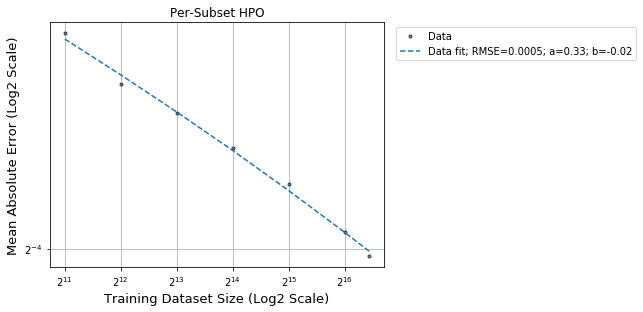

In [66]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ps_best['tr_size'], y = ps_best[met], title='Per-Subset HPO', **plot_fit_kwargs );

### LS-HPO
Extract the best performance score for the largest shard (for each metric)

In [35]:
best = top_n_runs(hp, tr_size=hp['tr_size'].max(), n=1, sort_by_metric=met, plot=False)
display(best)

,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,100,0.1,-1,2000,230441,0.043069,0.030065,0.817472


In [36]:
if 'nn' in str(base_dir):
    prm_names = ['dr_rate', 'opt', 'lr', 'batchnorm', 'batch_size']
elif 'lgbm' in str(base_dir):
    prm_names = ['gbm_trees', 'gbm_max_depth', 'gbm_lr', 'gbm_leaves']

In [37]:
# idx = pd.Series(True, index=range(hp.shape[0]))
# for c in prm_names:  idx = idx & ( hp[c] == best[c][0] )
# ls_best = hp[ idx ].sort_values('tr_size').reset_index(drop=True)

hp_cols = [c for c in dflt_hp_dct.keys()]
ls_hp_best_dct = {c: best[c].values[0] for c in hp_cols}
ls_best = extract_runs_by_specific_hps(hp, ls_hp_best_dct) # hp_ls_best

ls_best.to_csv(base_dir/'hpo_ls_best.csv', index=False)
display(ls_best)


,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,100,0.1,-1,2000,128,0.108182,0.092402,0.066382
1,100,0.1,-1,2000,256,0.101871,0.082251,0.134349
2,100,0.1,-1,2000,512,0.094300,0.071182,0.202265
3,100,0.1,-1,2000,1024,0.081241,0.060637,0.413493
4,100,0.1,-1,2000,2048,0.070422,0.050829,0.543028
5,100,0.1,-1,2000,4096,0.062453,0.044219,0.634225
6,100,0.1,-1,2000,8192,0.056167,0.040080,0.699191
7,100,0.1,-1,2000,16384,0.052662,0.036963,0.731794
8,100,0.1,-1,2000,32768,0.049754,0.034858,0.756350
9,100,0.1,-1,2000,65536,0.047964,0.033538,0.772793


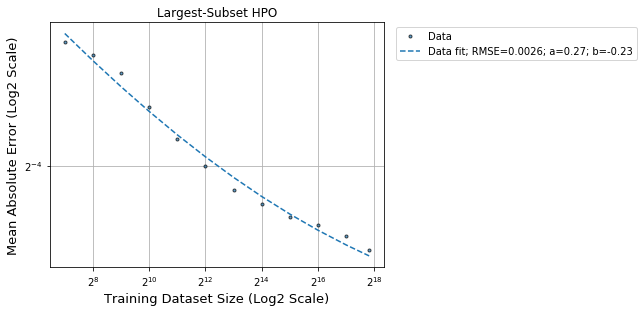

In [38]:
lrn_crv_plot.plot_lrn_crv_power_law( x = ls_best['tr_size'], y = ls_best[met], title='Largest-Subset HPO', **plot_fit_kwargs );

### Plot all data points

In [39]:
hp_dflt = extract_runs_by_specific_hps(hp, dflt_hp_dct)
display(hp_dflt)


,gbm_leaves,gbm_lr,gbm_max_depth,gbm_trees,tr_size,mean_absolute_error,median_absolute_error,r2
0,31,0.1,-1,100,128,0.108182,0.092402,0.066382
1,31,0.1,-1,100,256,0.101871,0.082251,0.134349
2,31,0.1,-1,100,512,0.094300,0.071182,0.202265
3,31,0.1,-1,100,1024,0.080684,0.060358,0.416658
4,31,0.1,-1,100,2048,0.069589,0.050038,0.552855
5,31,0.1,-1,100,4096,0.062528,0.045835,0.640409
6,31,0.1,-1,100,8192,0.057397,0.041596,0.690571
7,31,0.1,-1,100,16384,0.054251,0.038652,0.719293
8,31,0.1,-1,100,32768,0.051967,0.036875,0.738987
9,31,0.1,-1,100,65536,0.050867,0.035780,0.747913


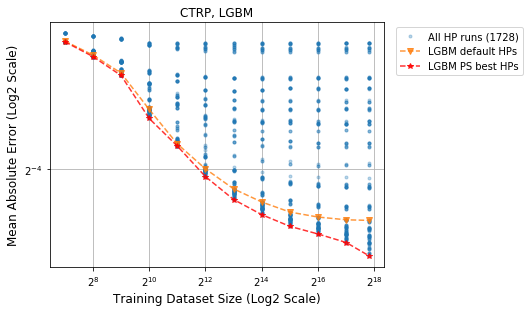

In [40]:
# matplotlib.org/3.1.0/api/markers_api.html#module-matplotlib.markers

# Plot all runs
ax = pp_utils.plot_all_from_hp_df(hp, **plot_all_kwargs, marker='.', alpha=0.3, title=f'{src.upper()}, {model.upper()}', label='All HP runs');

# Plot runs from default model HPs
ax.plot(hp_dflt['tr_size'], hp_dflt[met], ls='--', alpha=0.8, marker='v', label='LGBM default HPs');

# Plot runs from best LS-HPs applied to all shards
# ax.plot(ls_best['tr_size'], ls_best[met], ls='--', color='r', alpha=0.8, marker='*', label='LGBM LS best HPs');
ax.plot(ps_best['tr_size'], ps_best[met], ls='--', color='r', alpha=0.8, marker='*', label='LGBM PS best HPs');

ax.legend(frameon=True, fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left');

### Percent Improvement as compared to default model params

In [41]:
# display(hp_dflt)
# display(ps_best)

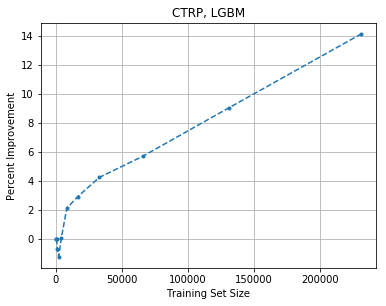

In [42]:
sizes = list(set(hp_dflt['tr_size']).intersection(set(ps_best['tr_size'])))
V0 = hp_dflt[ hp_dflt['tr_size'].isin(sizes) ]
# V1 = ps_best[ ps_best['tr_size'].isin(sizes) ] # PS-HPs
V1 = ls_best[ ls_best['tr_size'].isin(sizes) ] # LS-HPs

v0 = V0.loc[:,'mean_absolute_error']
v1 = V1.loc[:,'mean_absolute_error']
imp = (v0-v1)/v0*100
# imp = (v0-v1)

base, scale = lrn_crv_plot.scale_ticks_params(tick_scale='log2')

fig, ax = plt.subplots(figsize=figsize)
ax.plot(V0['tr_size'], imp, '.--'); plt.grid(True);
ax.set_title(f'{src.upper()}, {model.upper()}')
ax.set_ylabel('Percent Improvement')
ax.set_xlabel('Training Set Size');
# ax.set_xscale('log', basex=base)
# ax.set_yscale('log', basey=base)

### PS-HPO vs LS-HPO fit

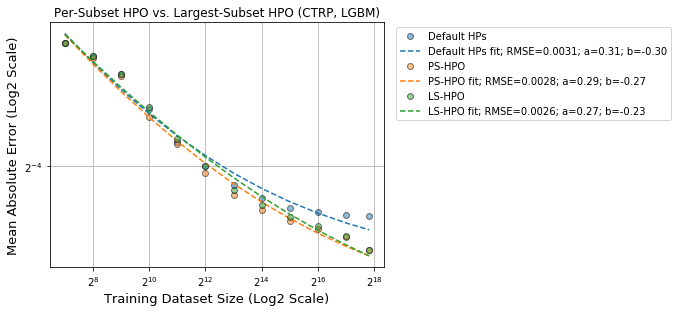

In [45]:
marker='o'; alpha=0.5

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=hp_dflt['tr_size'], y=hp_dflt[met],
                                                         marker=marker, alpha=alpha, label='Default HPs',
                                                         ax=None, **plot_fit_kwargs)

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ps_best['tr_size'], y=ps_best[met],
                                                         marker=marker, alpha=alpha, label='PS-HPO',
                                                         ax=ax, **plot_fit_kwargs)

ax, fit_prms, rmse = lrn_crv_plot.plot_lrn_crv_power_law(x=ls_best['tr_size'], y=ls_best[met],
                                                         marker=marker, alpha=alpha, label='LS-HPO', 
                                                         ax=ax, **plot_fit_kwargs,
                                                         title=f'Per-Subset HPO vs. Largest-Subset HPO ({src.upper()}, {model.upper()})')

## PS-HPO vs LS-HPO extrapolate

In [47]:
m0 = 11

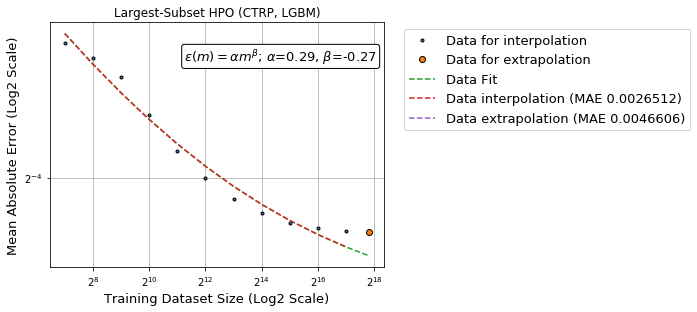

In [49]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=hp_dflt['tr_size'], y=hp_dflt[met],
                                           m0=m0, **plot_fit_kwargs, title=f'Largest-Subset HPO ({src.upper()}, {model.upper()})');

(<matplotlib.axes._subplots.AxesSubplot at 0x7f919630d0b8>,
 {'alpha': 0.25888572176835317,
  'beta': -0.22446258816360048,
  'gamma': 0.02502711955236917})

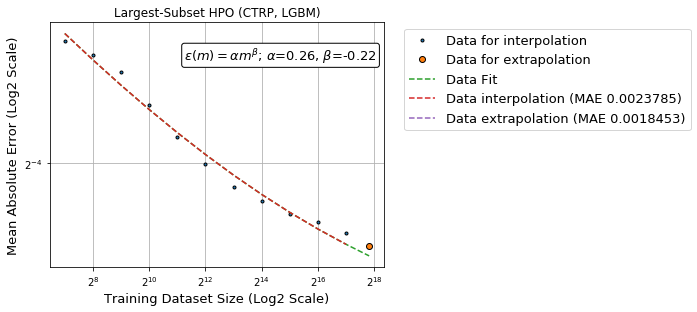

In [50]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ls_best['tr_size'], y=ls_best[met],
                                           m0=m0, **plot_fit_kwargs, title=f'Largest-Subset HPO ({src.upper()}, {model.upper()})');

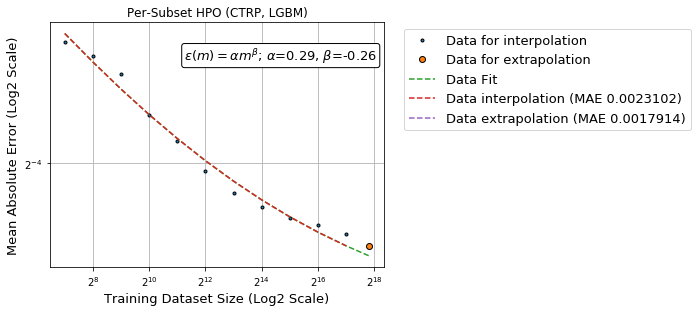

In [51]:
lrn_crv_plot.lrn_crv_power_law_extrapolate(x=ps_best['tr_size'], y=ps_best[met],
                                           m0=m0, **plot_fit_kwargs, title=f'Per-Subset HPO ({src.upper()}, {model.upper()})');